In [1]:
import pyarrow.parquet as pq
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
tqdm.pandas()

### Loading all data

#### Load Y

In [2]:
#Load the train dataframe
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [3]:
train_df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [4]:
train_df.info()
print(f"NaNs in train metadata: {train_df.isna().sum().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          106800 non-null  i

In [5]:
test_df.head()

,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   spectrogram_id  1 non-null      int64
 1   eeg_id          1 non-null      int64
 2   patient_id      1 non-null      int64
dtypes: int64(3)
memory usage: 152.0 bytes


Ok so we don't have any missing values in the train and test dataframes. Test is empty since it is dummy data. Now lets load in all the eeg data and check the shape of the data.

#### Load X (EEGs)

In [7]:
# Load all the train_eegs
def load_eegs():
    eegs = []
    # Get all eeg filenames
    eeg_files = os.listdir('../data/train_eegs')
    
    #Load all eegs into eegs list
    for eeg_file in tqdm(eeg_files):
        eegs.append(pq.read_table(f'../data/train_eegs/{eeg_file}').to_pandas())
    return eegs, eeg_files

In [8]:
def save_eegs(eegs, eeg_files):
    files = [x.split('.')[0] for x in eeg_files]
    
    #For each eeg, add files as a column
    for eeg, curr_file in zip(eegs, files):
        eeg['file'] = curr_file
    
    #Concatenate all eegs into one dataframe
    eegs = pd.concat(eegs)

    #Save the eegs to a single parquet file
    eegs.to_parquet(f'../data/train_eegs.parquet')
    return eegs

In [9]:
# Check if train_eegs.parquet exists
if os.path.exists('../data/train_eegs.parquet'):
    eegs = pd.read_parquet('../data/train_eegs.parquet')
    eeg_files = os.listdir('../data/train_eegs')
else:
    eegs, eeg_files = load_eegs()
    eegs = save_eegs(eegs, eeg_files)

In [10]:
eegs.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,...,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG,file
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,...,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054,1000913311
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,...,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922,1000913311
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,...,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049,1000913311
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,...,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054,1000913311
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,...,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117,1000913311


In [11]:
eegs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280905200 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fp1     float32
 1   F3      float32
 2   C3      float32
 3   P3      float32
 4   F7      float32
 5   T3      float32
 6   T5      float32
 7   O1      float32
 8   Fz      float32
 9   Cz      float32
 10  Pz      float32
 11  Fp2     float32
 12  F4      float32
 13  C4      float32
 14  P4      float32
 15  F8      float32
 16  T4      float32
 17  T6      float32
 18  O2      float32
 19  EKG     float32
 20  file    object 
dtypes: float32(20), object(1)
memory usage: 25.1+ GB


#### Load X (Spectrograms)

In [12]:
# Load all the train_spectrograms
def load_spectrograms():
    spectrograms = []
    # Get all spectrogram filenames
    spectrogram_files = os.listdir('../data/train_spectrograms')
    
    #Load all spectrograms into spectrograms list
    for spectrogram_file in tqdm(spectrogram_files):
        spectrograms.append(pq.read_table(f'../data/train_spectrograms/{spectrogram_file}').to_pandas())
    return spectrograms, spectrogram_files

In [13]:
def save_spectrograms(spectrograms, spectrogram_files):
    files = [x.split('.')[0] for x in spectrogram_files]
    
    #For each spectrogram, add files as a column
    for spectrogram, curr_file in zip(spectrograms, files):
        spectrogram['file'] = curr_file
    
    #Concatenate all spectrograms into one dataframe
    spectrograms = pd.concat(spectrograms)

    #Save the spectrograms to a single parquet file
    spectrograms.to_parquet(f'../data/train_spectrograms.parquet')
    return spectrograms

In [14]:
# Check if train_spectrograms.parquet exists
if os.path.exists('../data/train_spectrograms.parquet'):
    spectrograms = pd.read_parquet('../data/train_spectrograms.parquet')
else:
    spectrograms, spectrogram_files = load_spectrograms()
    spectrograms = save_spectrograms(spectrograms, spectrogram_files)

In [15]:
spectrograms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4279506 entries, 0 to 315
Columns: 402 entries, time to file
dtypes: float32(400), int64(1), object(1)
memory usage: 6.5+ GB


## Investigations
Now that we have all the data loaded, we can start investigating the data. We will start by looking at NaNs

### NaNs

In [16]:
# Print the percentage of NaNs in for each column (feature)
eegs_nan = eegs.isna().mean() * 100

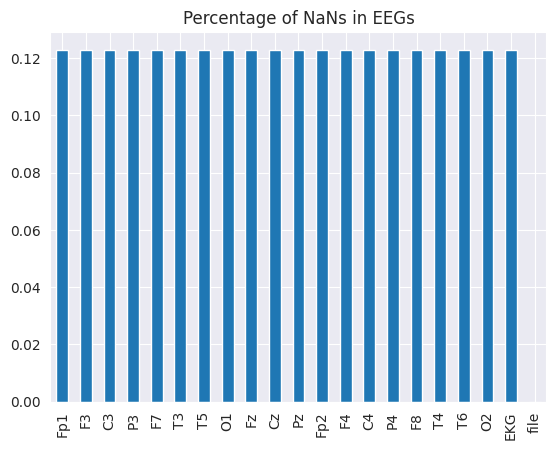

In [17]:
eegs_nan.plot(kind='bar', title='Percentage of NaNs in EEGs')

#Save plot
plt.savefig('../plots/eegs_nans.png')

In [18]:
# Print NaNs in spectrograms
spectrograms_nan = spectrograms.isna().mean() * 100

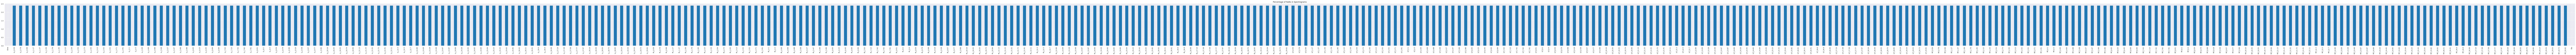

In [19]:

fig, ax = plt.subplots(figsize=(300, 5))
spectrograms_nan.plot(kind='bar', title='Percentage of NaNs in Spectrograms')

#Save plot
plt.savefig('../plots/spectrograms_nans.png')

In [20]:
print(spectrograms_nan)

time        0.000000
LL_0.59     2.400324
LL_0.78     2.400324
LL_0.98     2.400324
LL_1.17     2.400324
              ...   
RP_19.34    2.400324
RP_19.53    2.400324
RP_19.73    2.400324
RP_19.92    2.400324
file        0.000000
Length: 402, dtype: float64


In [21]:
print(f"Percentage of NaNs in Eegs: {(eegs.isna().sum().sum() / (eegs.shape[0] * eegs.shape[1])) * 100}%")
print(f"Percentage of NaNs in Spectrograms: {(spectrograms.isna().sum().sum() / (spectrograms.shape[0] * spectrograms.shape[1])) * 100}%")

Percentage of NaNs in Eegs: 0.11704033280707546%
Percentage of NaNs in Spectrograms: 2.388381866356347%


From this we can observe that, there is around 0.12% Nans in EEGS and 2.4% in Specrograms. If there is a NaN, all features are NaNs. This is good to know. Now we can start looking at the distribution of the data.

### Distribution analysis

#### EEGs

In [22]:
# Lets take a look at the boxplots of the eegs using sns
import seaborn as sns
# Slice eegs to a small part to analyse the distribution (first 6 files
eeg_dummy = []

for i in range(6):
    curr_file = eeg_files[i].split('.')[0]
    eegs_slice = eegs[eegs['file'] == curr_file]
    eegs_slice = eegs_slice.drop(columns=['file', 'EKG'])
    eeg_dummy.append(eegs_slice)

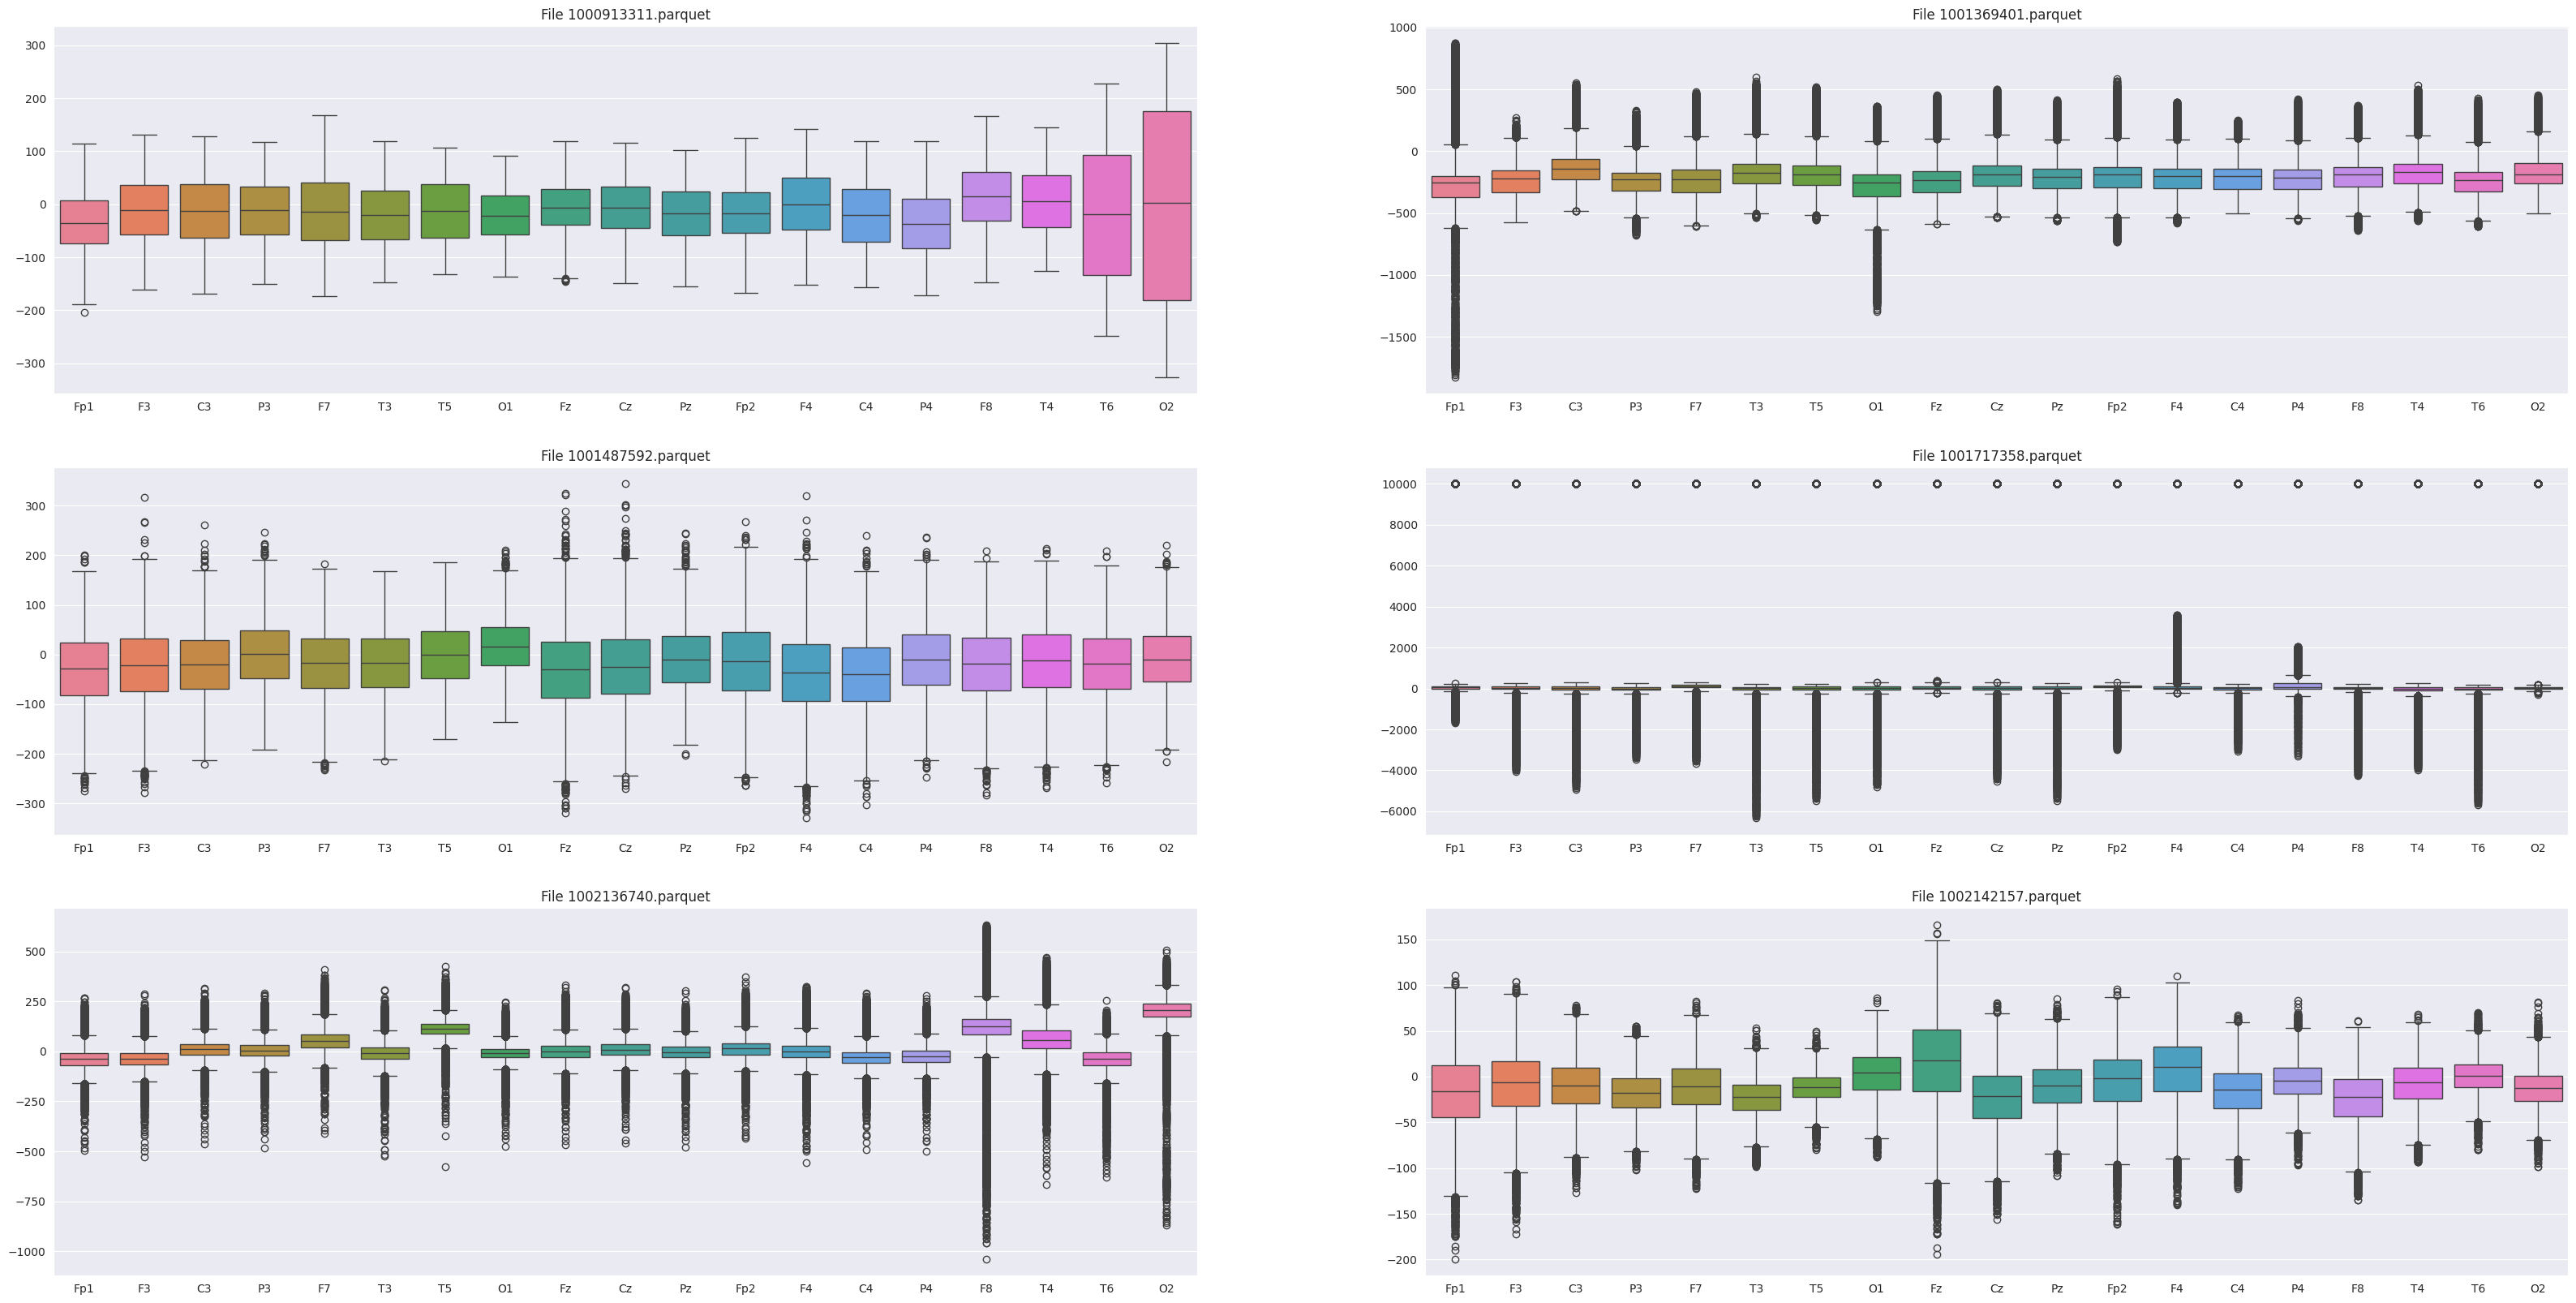

In [23]:
fig, ax = plt.subplots(figsize=(40, 20), nrows=3, ncols=2)
#Plot the results.
for i in range(3):
    for j in range(2):
        sns.boxplot(data=eeg_dummy[i*2+j], ax=ax[i, j])
        ax[i, j].set_title(f'File {eeg_files[i*2+j]}')

We can observe that there might be some weird eegs that have crazy outlier voltages. Some of them reaching 10000 + 

Text(0, 0.5, 'Microvolts')

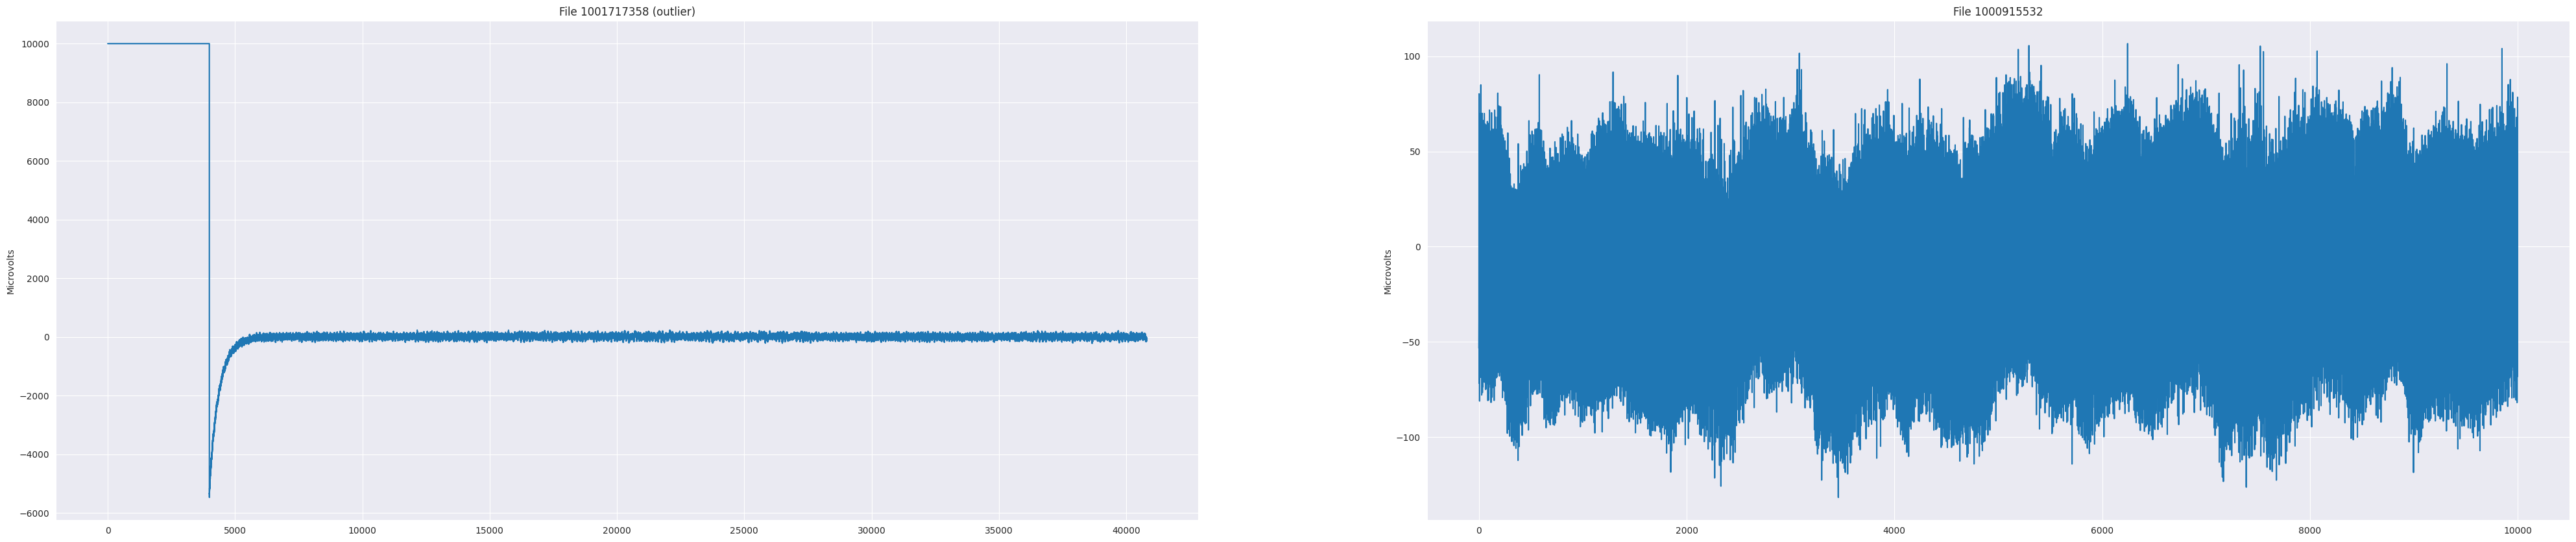

In [26]:
import seaborn as sns
# Ok lets plot the sensor data of 1001717358 against a more 'normal' one. Let's make a lineplot.
fig, ax = plt.subplots(figsize=(50, 10), nrows=1, ncols=2)

sns.lineplot(data=eeg_dummy[3]["T5"], ax=ax[0])
sns.lineplot(data=eeg_dummy[0]["T5"], ax=ax[1])
ax[0].set_title('File 1001717358 (outlier)')
ax[1].set_title('File 1000915532')
#Set the y-axis to microvolts
ax[0].set_ylabel('Microvolts')
ax[1].set_ylabel('Microvolts')

Text(0, 0.5, 'Microvolts')

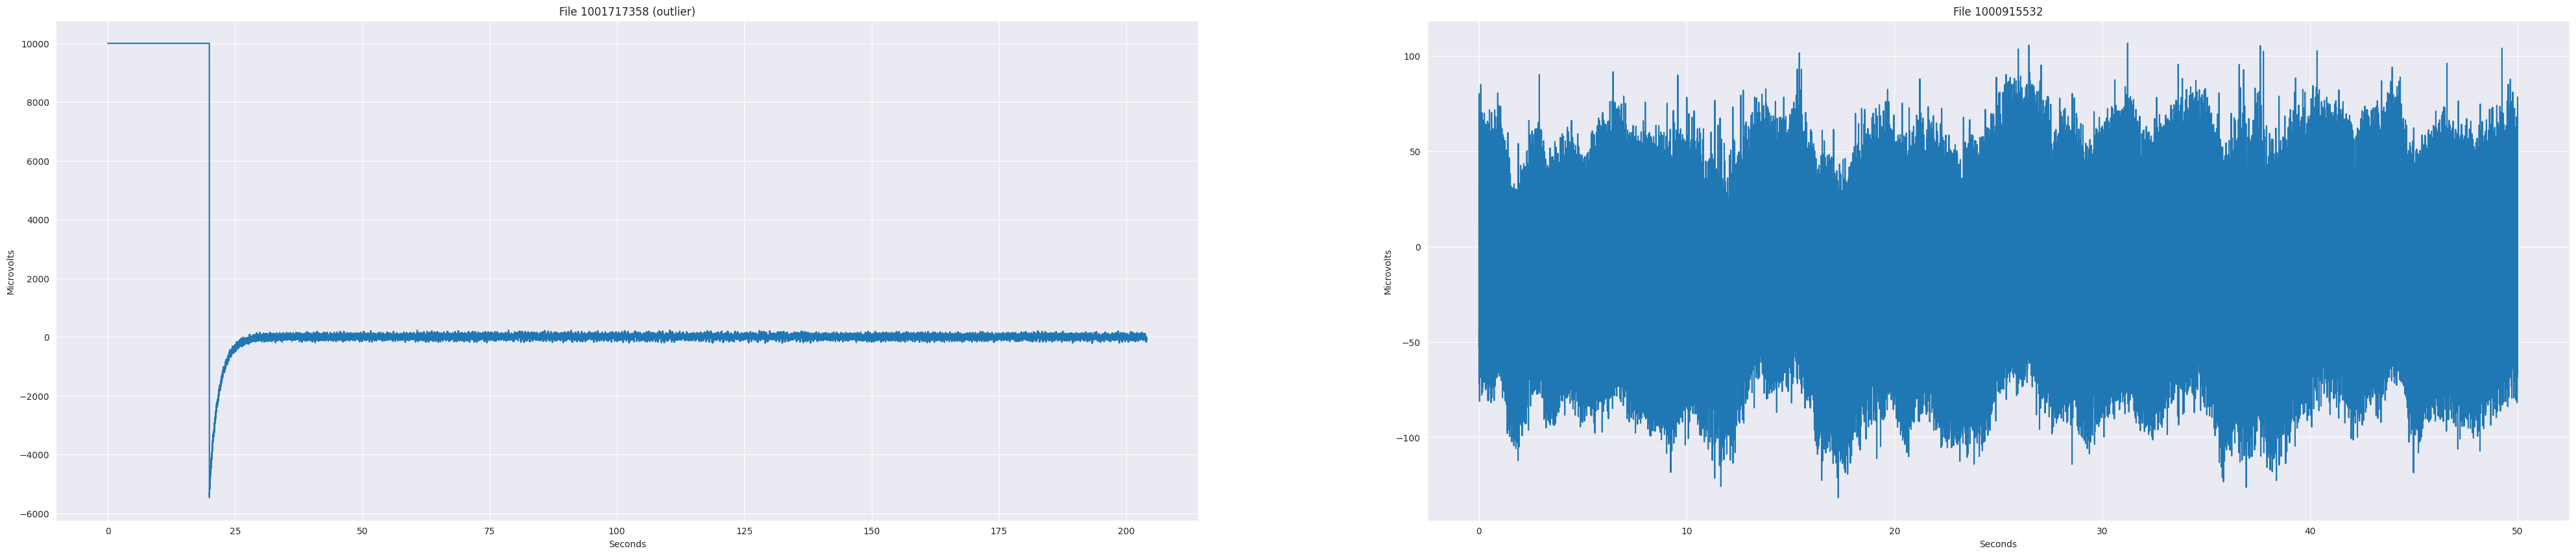

In [27]:
#Ok now lets make the x-axis in seconds given a sampling rate of 200Hz.
fig, ax = plt.subplots(figsize=(50, 10), nrows=1, ncols=2)
x0 = [i / 200 for i in range(eeg_dummy[3]["T5"].shape[0])]
x1 = [i / 200 for i in range(eeg_dummy[0]["T5"].shape[0])]
sns.lineplot(x=x0, y=eeg_dummy[3]["T5"], ax=ax[0])
sns.lineplot(x=x1, y=eeg_dummy[0]["T5"], ax=ax[1])
ax[0].set_title('File 1001717358 (outlier)')
ax[1].set_title('File 1000915532')
#Set the xaxis to seconds
ax[0].set_xlabel('Seconds')
ax[1].set_xlabel('Seconds')
#Set the y-axis to microvolts
ax[0].set_ylabel('Microvolts')
ax[1].set_ylabel('Microvolts')


This is interesting. We might want to drop data that is not in the range of ~500 to 500 microvolts. This is because the data is not in the range of the normal eeg data. It might be that the sensor is broken or something. It could be of multiple reasons:
- Sensor is broken.
- Sensor is not connected yet and is therefore static.
- Sensor is not placed correctly.
- Unlikely? Sensor is saturated to the max

### Investigations - Labels
So now we know that there are some crazy outliers in the eegs. Now lets look at labelling and show lineplots where there is a seizure and where there is not a seizure.

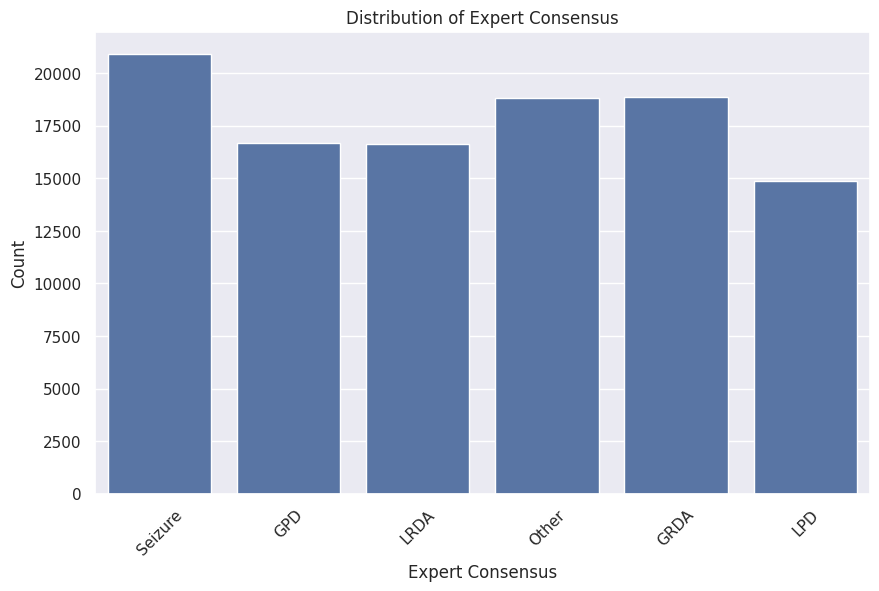

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='expert_consensus')
plt.title('Distribution of Expert Consensus')
plt.xlabel('Expert Consensus')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

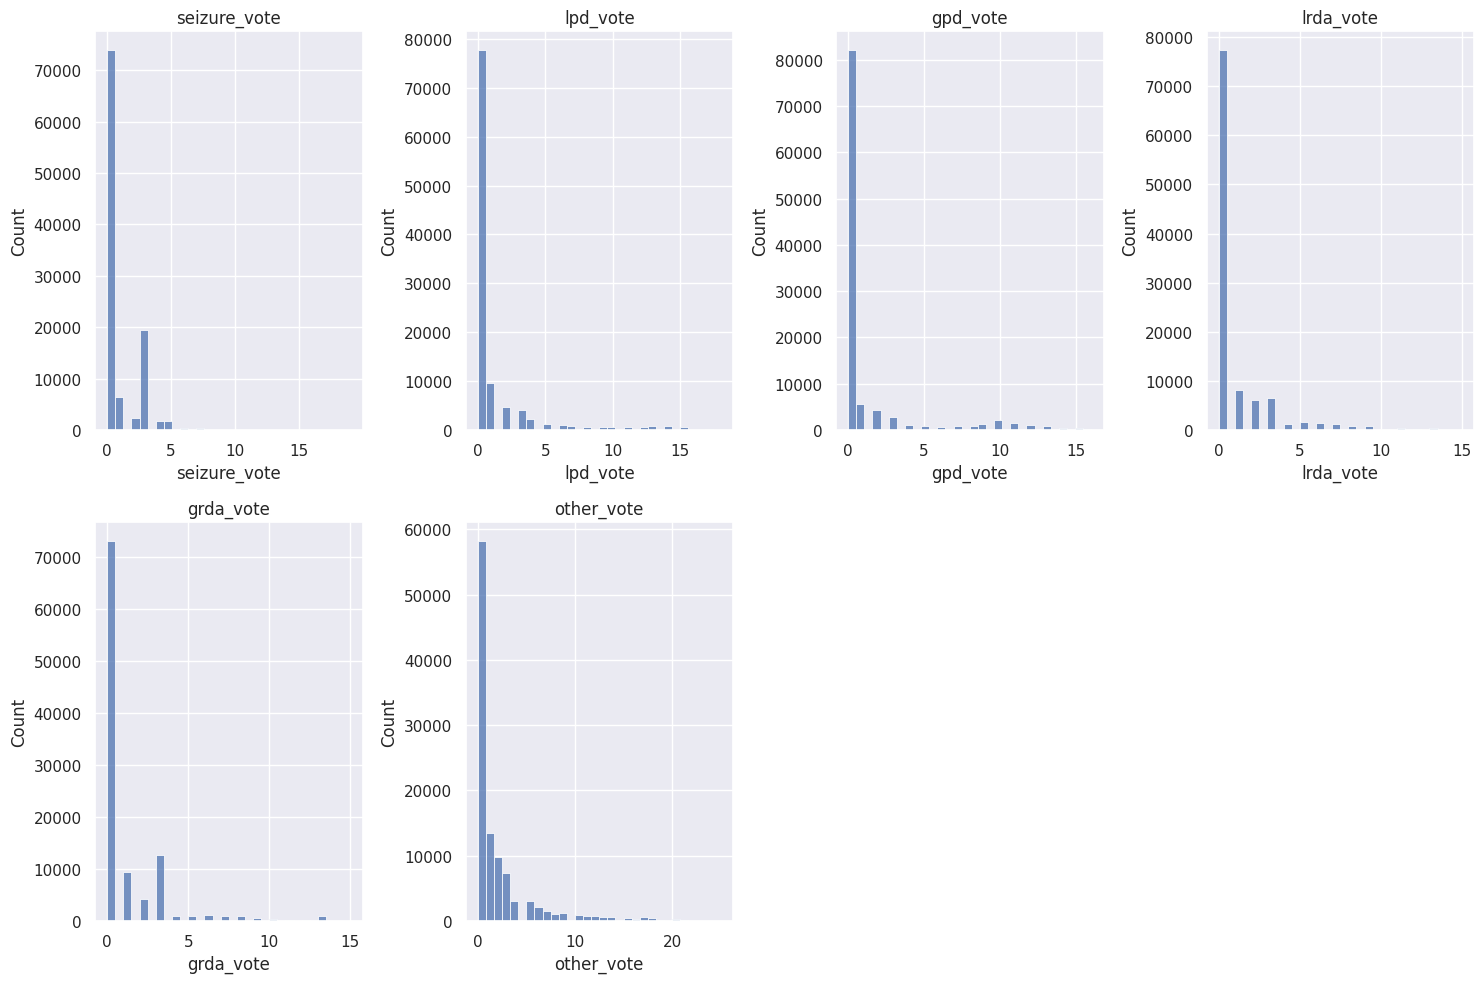

In [35]:
targets = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


plt.figure(figsize=(15, 10))
for i, column in enumerate(targets, 1):
    plt.subplot(2, 4, i)
    sns.histplot(train_df[column], kde=False, bins=30)
    plt.title(column)
plt.tight_layout()

In [49]:
vote_counts_by_consensus = train_df.groupby('expert_consensus')[targets].sum()
vote_counts_by_consensus.head(6)

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
expert_consensus,,,,,,
GPD,17935,7782,119196,938,5473,16334
GRDA,580,1908,3699,4757,85187,18376
LPD,4042,93640,4096,9691,1635,14603
LRDA,2351,7816,1266,75474,7280,22495
Other,2934,8875,5485,9542,13214,135498
Seizure,65931,1601,1352,876,332,2693


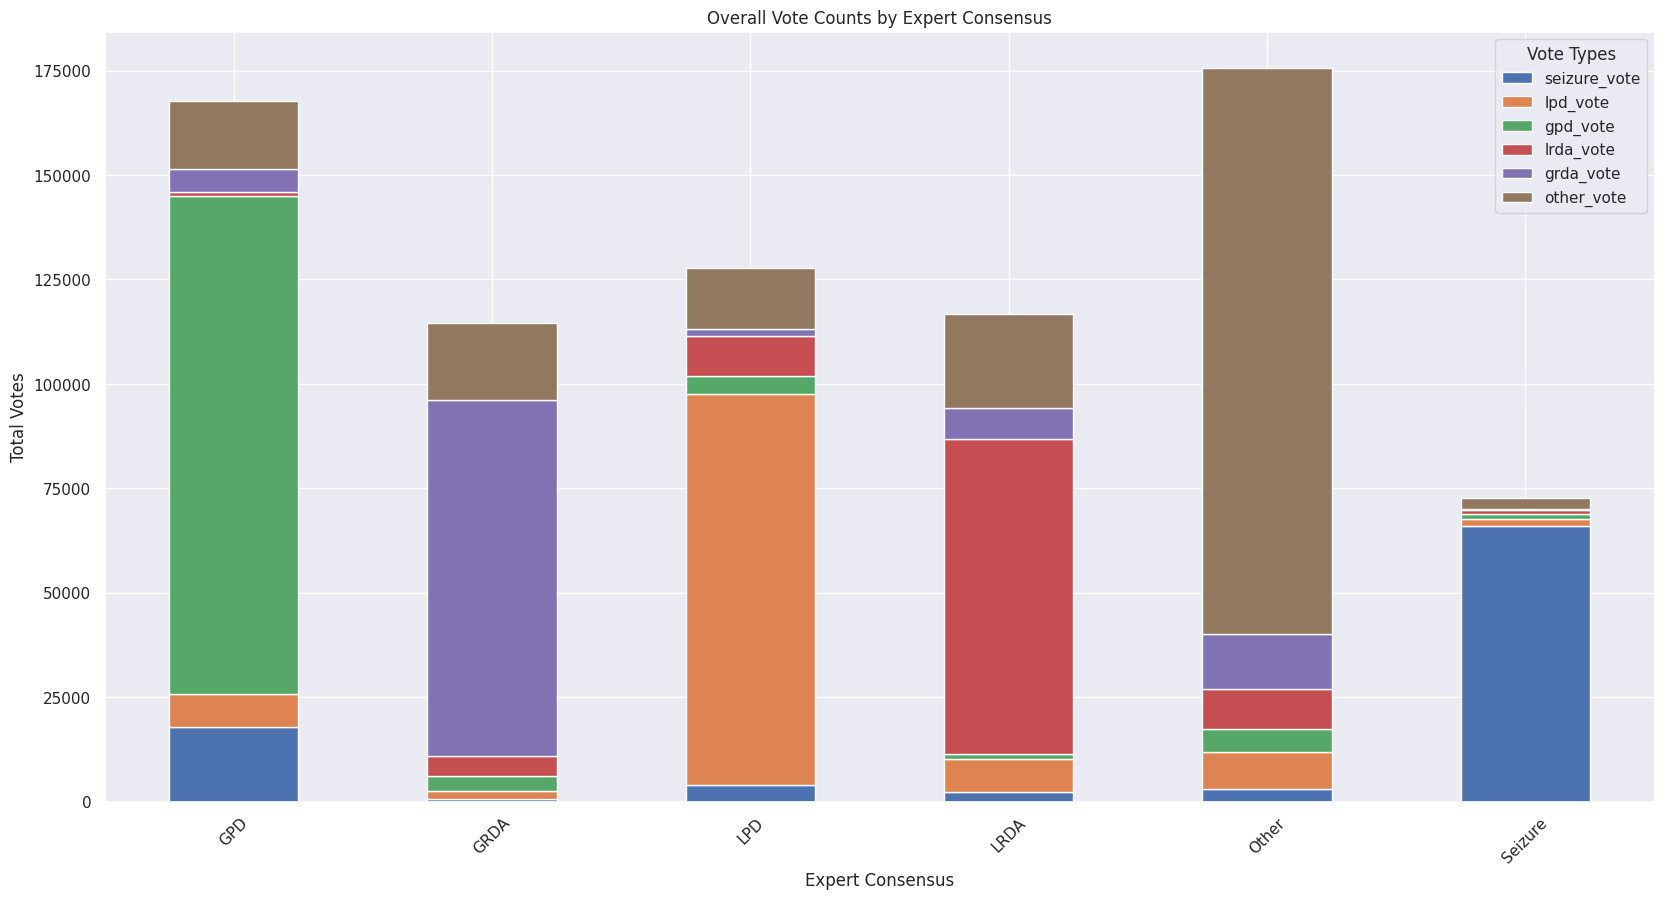

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))
vote_counts_by_consensus.plot(kind='bar', stacked=True,ax=ax)
plt.title('Overall Vote Counts by Expert Consensus')
plt.xlabel('Expert Consensus')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.legend(title='Vote Types')
plt.show()

GPD        10.038199
GRDA        6.071099
LPD         8.596325
LRDA        7.012139
Other       9.333688
Seizure     3.477046
dtype: float64


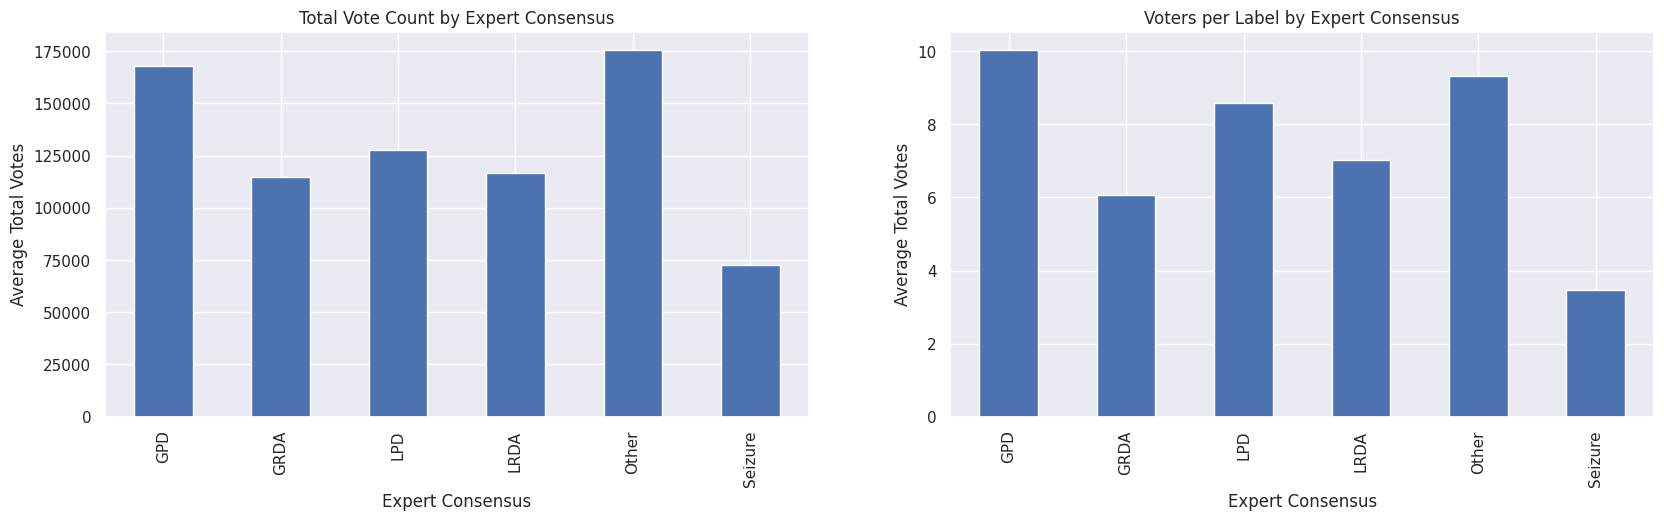

In [96]:
# For every type of anomaly, get the average total vote count
votes = vote_counts_by_consensus.sum(axis=1)

#Make a bar plot
fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)
votes.plot(kind='bar', ax=ax[0])
ax[0].set_title('Total Vote Count by Expert Consensus')
ax[0].set_xlabel('Expert Consensus')
ax[0].set_ylabel('Average Total Votes')

#Ok now lets divide these votes by the label distribution, so we obtain the average vote count per label.

voters_per_label = votes / train_df['expert_consensus'].value_counts()
print(voters_per_label)
voters_per_label.plot(kind='bar', ax=ax[1])
ax[1].set_title('Voters per Label by Expert Consensus')
ax[1].set_xlabel('Expert Consensus')
ax[1].set_ylabel('Average Total Votes')
plt.show()

Interesting to see that now all classes have the same amount of votes. Seizure is on average determined by only 3-4 experts while GPD needed 10 voters. We might be able to do something with this information by weighting the loss for example. It might be that a vote done by 10 experts is more valuable than a vote done by 3 experts. Therefore we might want to weight the loss function based on the amount of votes. This is something to keep in mind.

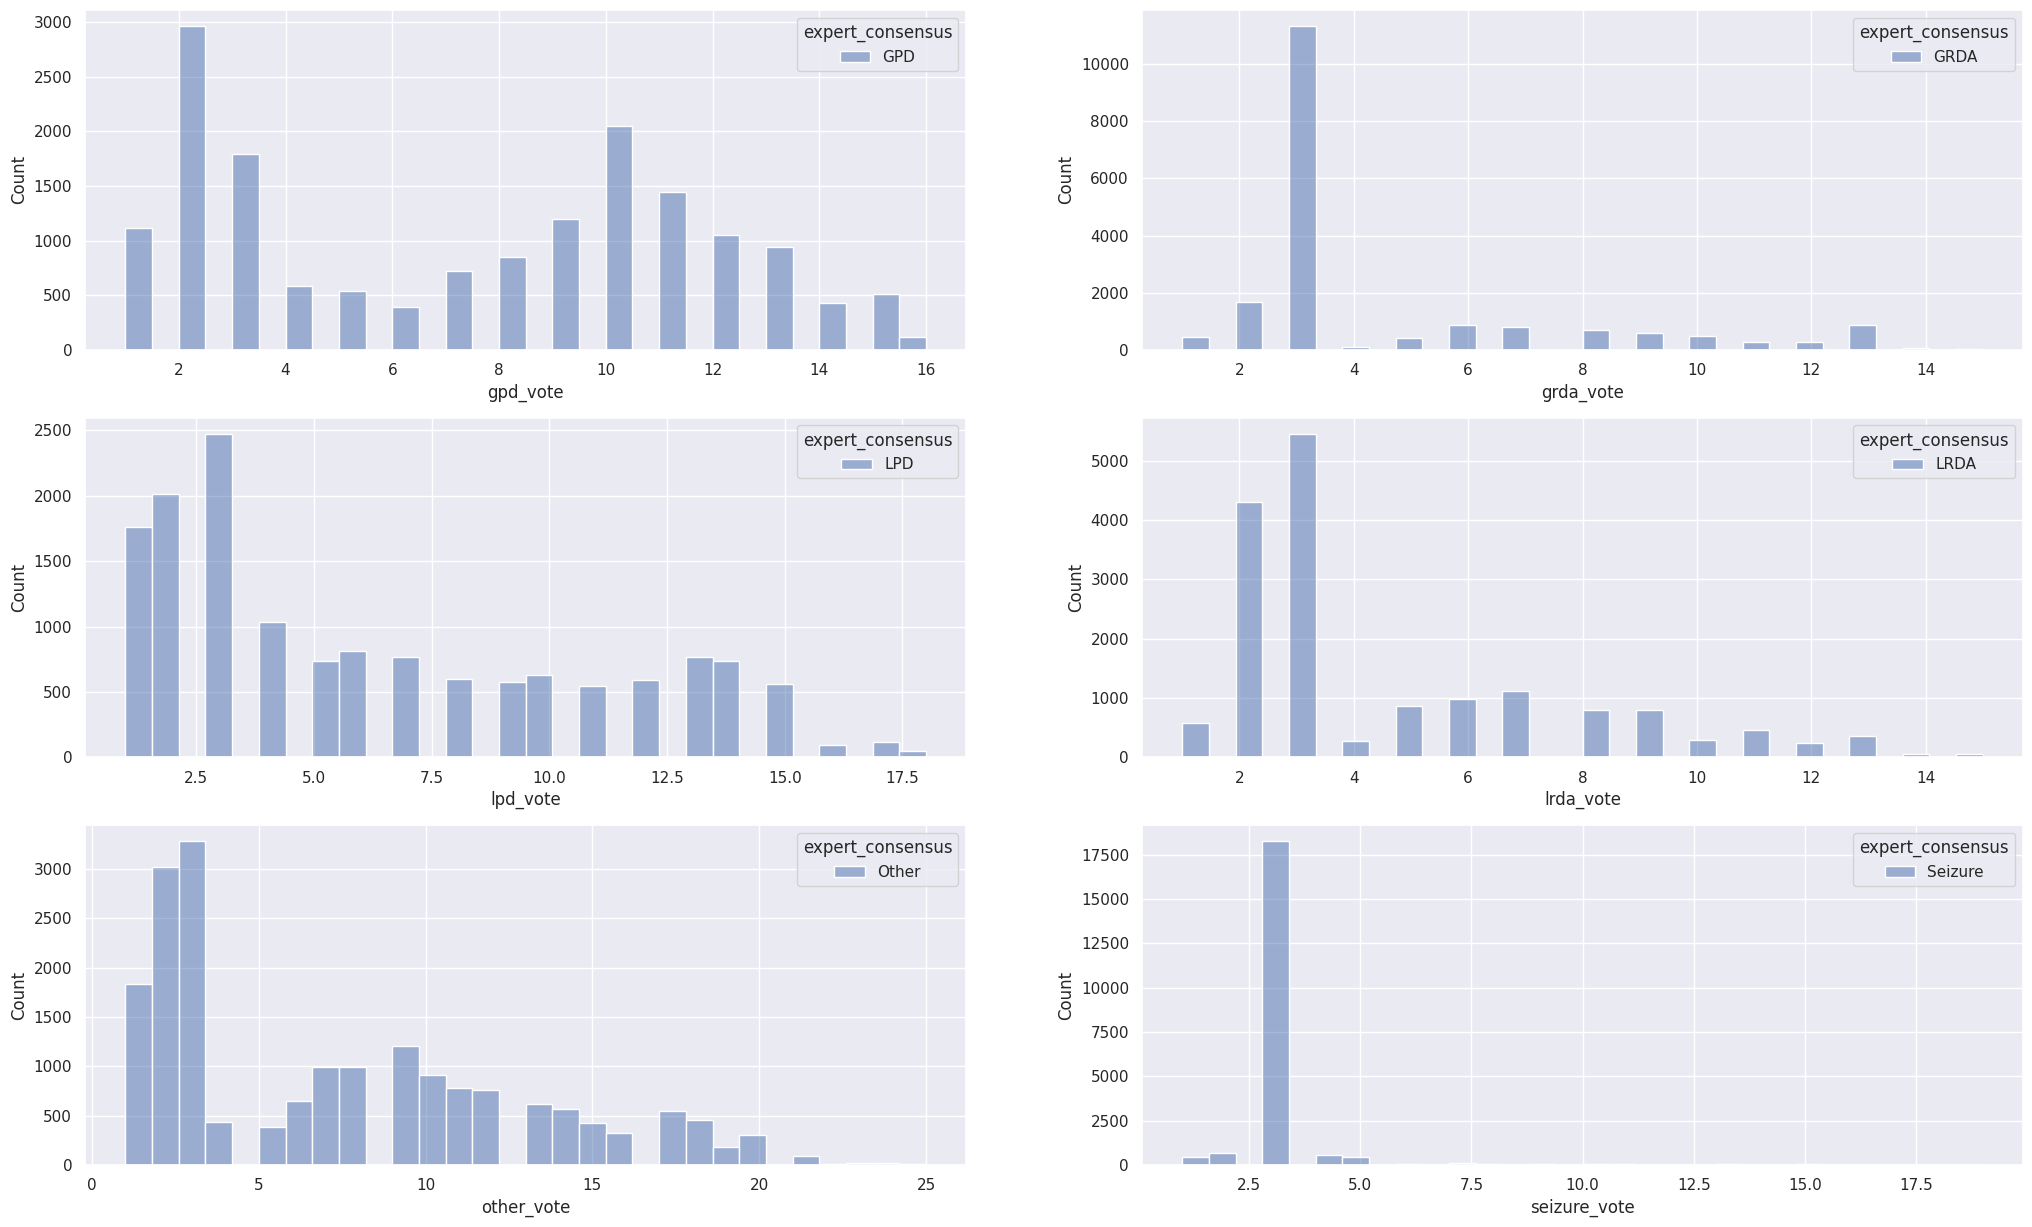

In [94]:
# Now lets look at the histogram of the number of voters per label
label_types = train_df['expert_consensus'].unique()
#Sort alphabetically
label_types = sorted(label_types)
targets = sorted(targets)

fig, ax = plt.subplots(figsize=(25, 15), nrows=3, ncols=2)
for i in range(len(targets)):
    sns.histplot(data=train_df[train_df["expert_consensus"] == label_types[i]], x=targets[i], hue="expert_consensus", bins=30, ax=ax[i//2, i%2])
    

<Axes: >

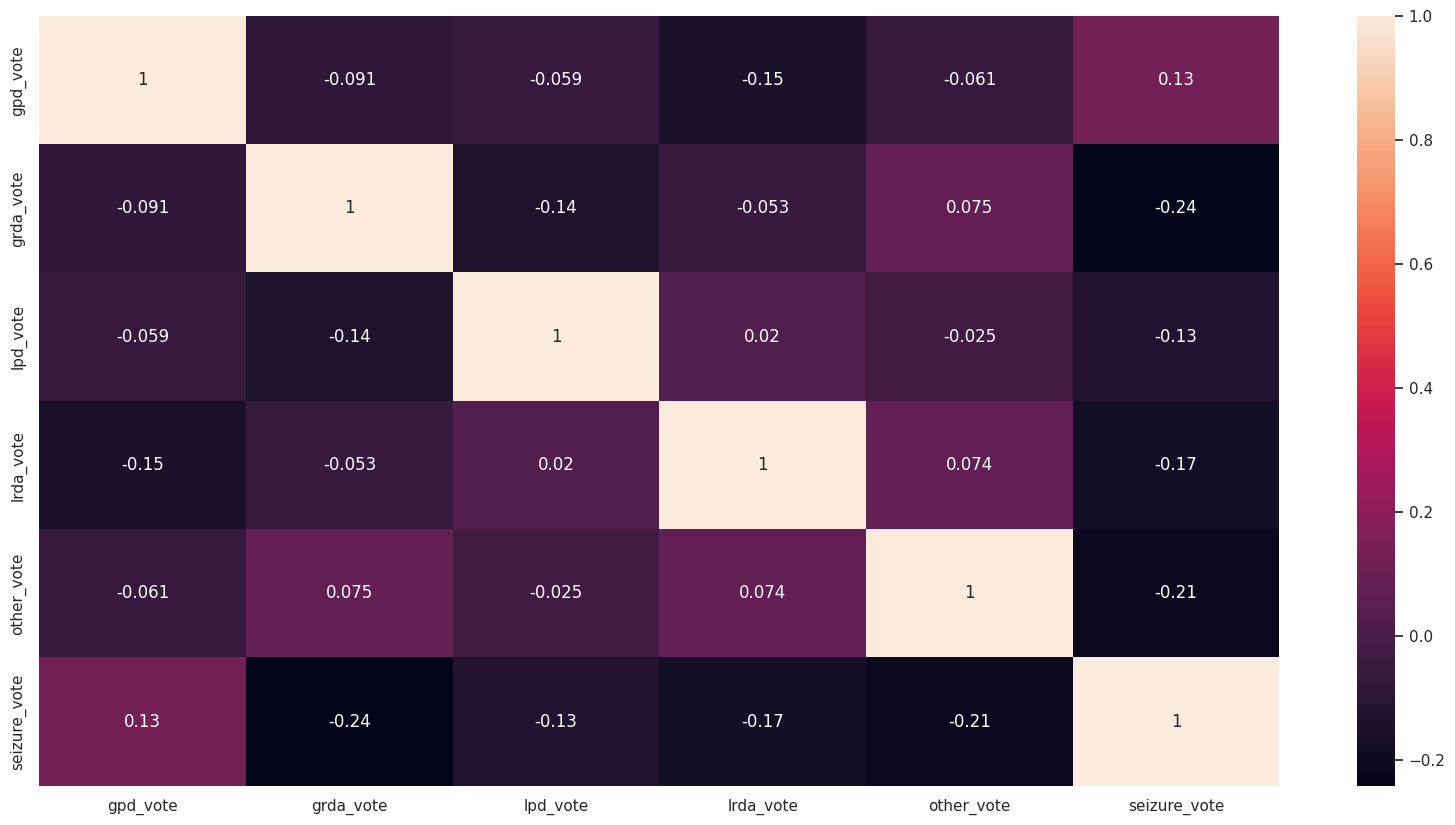

In [97]:
# Now lets take a look at the consensus of the votes for each class
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(train_df[targets].corr(), annot=True, ax=ax)

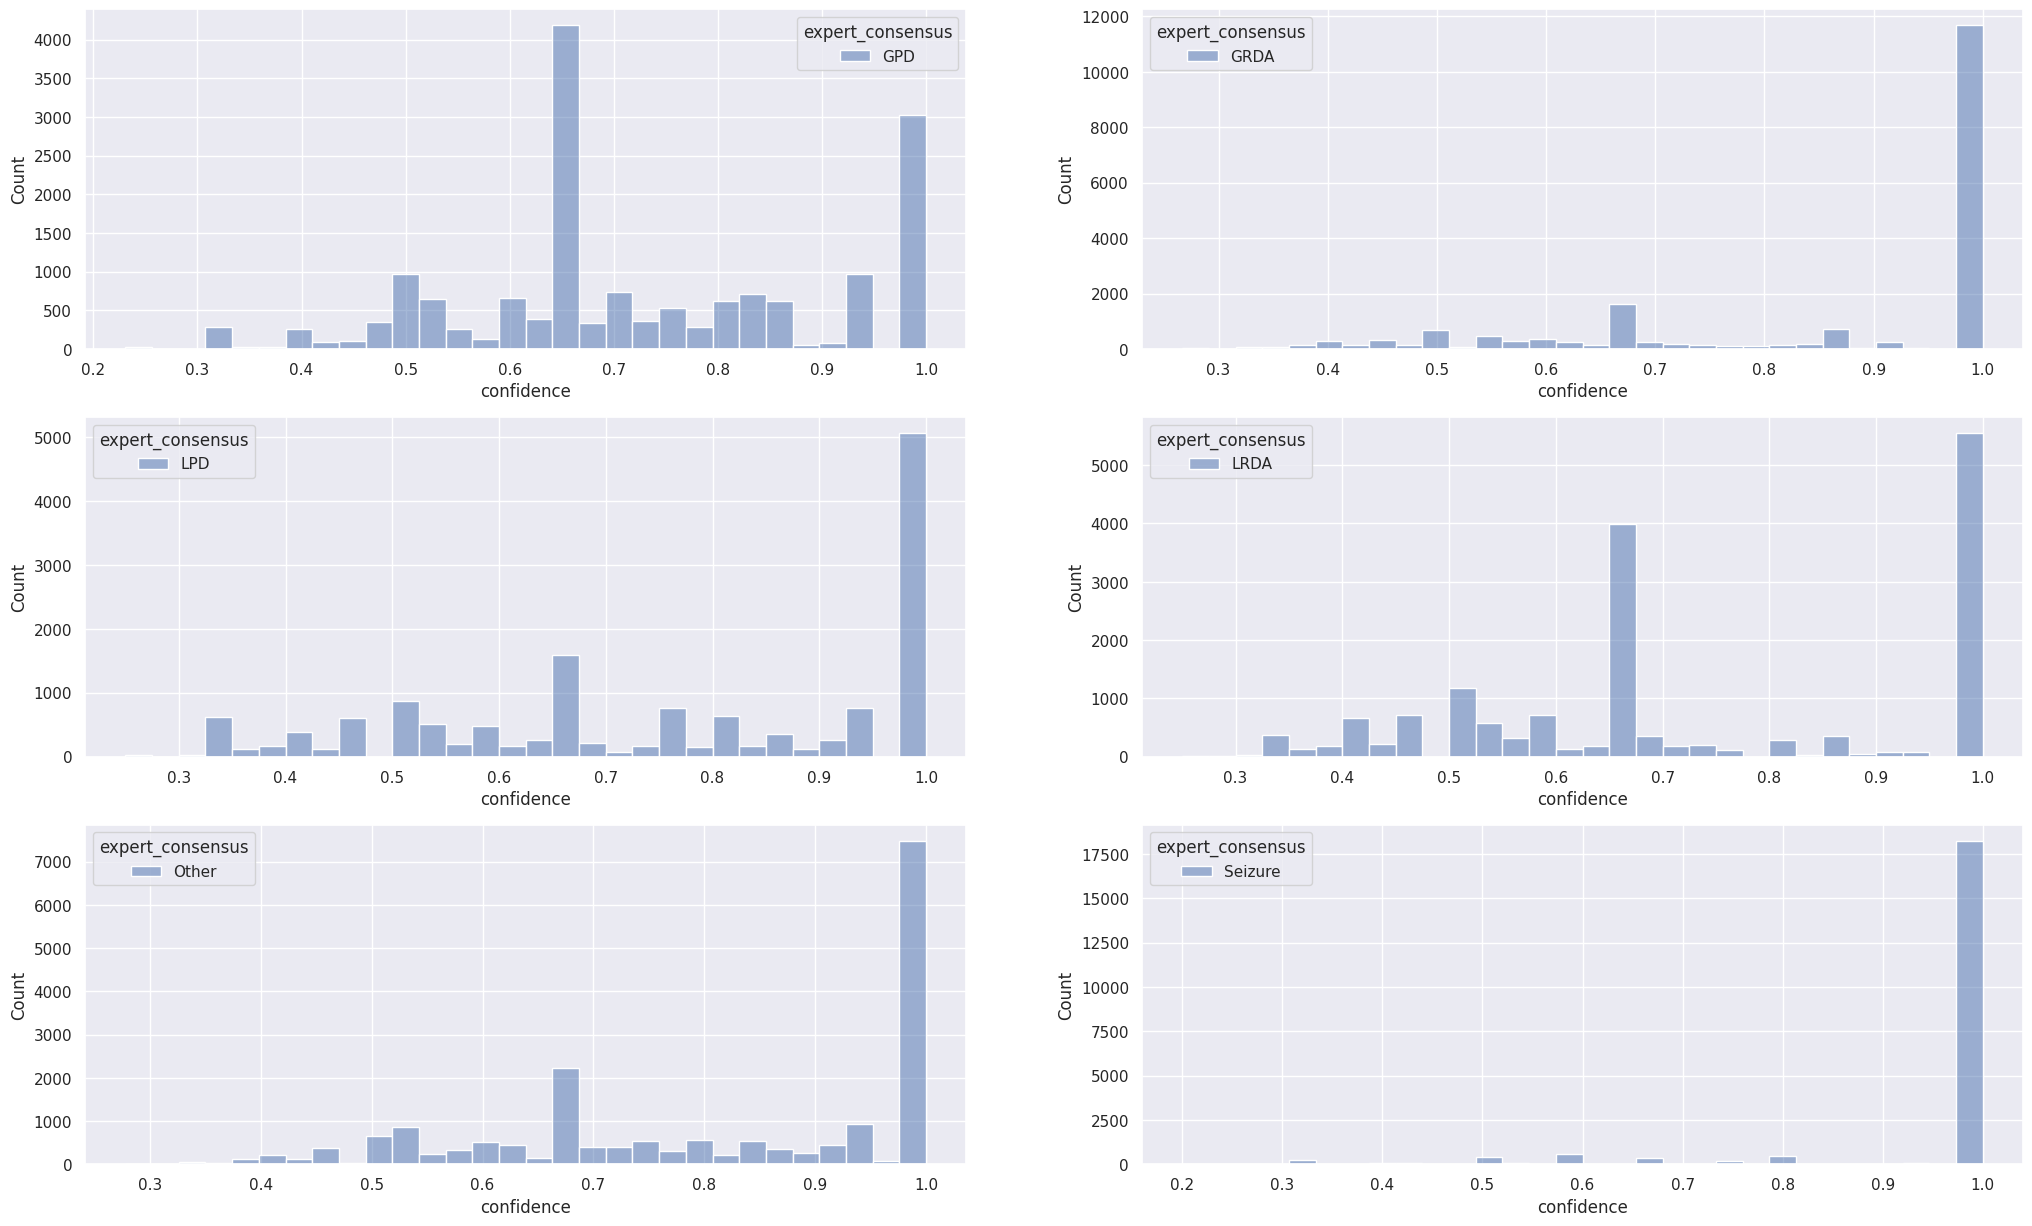

In [102]:
# For each expert consensus, get the confidence of the eventual vote.
# For each row, get the max of the targets and divide by the sum of the targets
confidence = train_df[targets].max(axis=1) / train_df[targets].sum(axis=1)
train_df["confidence"] = confidence

fig, ax = plt.subplots(figsize=(25, 15), nrows=3, ncols=2)
for i in range(len(targets)):
    sns.histplot(data=train_df[train_df["expert_consensus"] == label_types[i]], x="confidence", hue="expert_consensus", bins=30, ax=ax[i//2, i%2])
    

So now we know that there are some crazy outliers in the eegs. Now lets look at labelling and show lineplots where there is a seizure and where there is not a seizure.
@TODO: Visualize EEG data for each type of label of multiple patients.
@TODO: Visualize spectrogram data for each type of label of multiple patients.

@TODO: Are there multiple EEGs for the same patient?
@TODO: Are there multiple spectrograms for the same patient?

@TODO: How do we handle NaNs in the EEGs and Spectrograms?
@TODO: What is the pattern of the NaNs? Is it sequential or random inserted NaNs?

